# Analyze previous games data

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
# data is stored in the output.txt file
# first convert it to pandas df
column_names = ['Time', 'Drawn1','Drawn2','Drawn3','Drawn4','Drawn5','Drawn6','Drawn7','Drawn8','Drawn9','Drawn10','Drawn11','Drawn12','Drawn13','Drawn14','Drawn15','Drawn16','Drawn17','Drawn18','Drawn19','Drawn20','Drawn21','Drawn22','Drawn23','Drawn24','Drawn25','Drawn26','Drawn27','Drawn28','Drawn29','Drawn30','Drawn31','Drawn32','Drawn33','Drawn34','Drawn35']
data = pd.read_csv('output.txt',error_bad_lines=False,names=column_names)
data['Time'] = pd.to_datetime(data['Time'], format="%d.%m.%Y. - %H:%M :")
data.set_index('Time', inplace=True)

/Users/andrijastankovic/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


## Check the drawn data against mathematical probabilities

In [4]:
# setup dictionary of probabilities

# GAME RULES: - there are 1-48 numbers in one round for selection,
#        out of which 35 are boing drawn. 
#        - user picks 6 numbers to play with
#        - if all of his 6 numbers are drawn, 
#.         he wins money back multiplied with coefficient depending on the drawn position:

multipliers = [0, 0, 0, 0, 0,10000,7500,5000,2500,1000,500,300,200,150,100,80,60,40,30,25,20,18,16,14,12,10,9,8,7,6,5,4,3,2,1]
multipliers = pd.Series(multipliers, index=range(1, len(multipliers) + 1))

In [172]:
# now get probabilities for drawings
def combination(n, k):
    return math.comb(n, k)

# Vectorize the combination function
v_comb = np.vectorize(combination)

drawings_array = np.array(range(1,36))
drawn_numbers = 6

probabilityOf35 = v_comb(drawings_array, np.full((35,), drawn_numbers))
probabilityOf48 = np.full((35,), math.comb(48,6))

probability_to_win_per_drawing = probabilityOf35 / probabilityOf48
# convert to pandas series with index 1-35
probability_to_win_per_drawing = pd.Series(probability_to_win_per_drawing, index=range(1, len(probability_to_win_per_drawing) + 1))

In [190]:
# define function for getting the winning index in a game if all matched 
def find_last_match_index(row, selected_six):
    seen = set()
    for idx, num in enumerate(row):
        seen.add(num)
        if selected_six.issubset(seen):
            return int(idx + 1)
    return None

In [ ]:
# check the data for a random set of 6 numbers and get the success rate and compare to the mathematical prob
list_of_random_played_numbers = []
list_of_calcd_probabilities = []
list_of_winnings = []

for i in range(1,100):
    random_set = random.sample(range(1, 48), 6)
    list_of_random_played_numbers.append(random_set)
    
    # get calculated probabilities
    winnings = data.apply(lambda row: find_last_match_index(row, set(random_set)), axis=1)
    list_of_winnings.append(winnings)
    # fill in indexing as some of the numbers could be missing
    prob_of_winning = winnings.value_counts() / len(data)
    prob_of_winning.index = prob_of_winning.index.astype(int)
    prob_of_winning = prob_of_winning.reindex(range(1, prob_of_winning.index.max() + 1), fill_value=0)
    list_of_calcd_probabilities.append(prob_of_winning)

<b>winnings</b> will be used in the code for a series of indexes over datetime for specific combination. basically mapping winnings to multipliers gets you resulting yield (which can be summed and multiplied by bet to get the result in money)

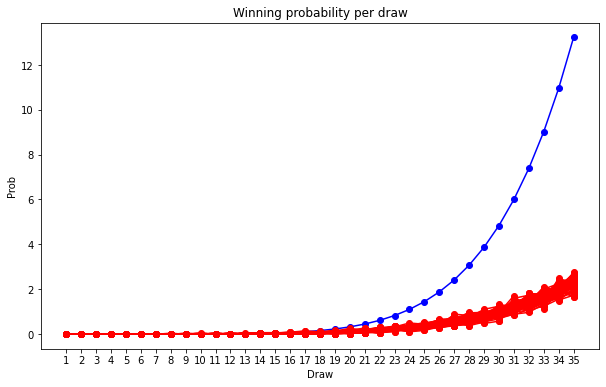

In [178]:
# visualize
import matplotlib.pyplot as plt

percentages = probability_to_win_per_drawing * 100
# show math probability
plt.figure(figsize=(10,6))
percentages.plot(marker='o', linestyle='-', color='b')
plt.title('Winning probability per draw')
plt.xlabel('Draw')
plt.ylabel('Prob')
plt.grid(True)
plt.xticks(list(percentages.index))  # ensure x-ticks align with Series' index values

# show random games winning rates
for game in list_of_calcd_probabilities:
    percentages = game * 100
    percentages.plot(marker='o', linestyle='-', color='r')

plt.show()

In [186]:
max_winning_rate = []
for game in list_of_calcd_probabilities:
    max_winning_rate.append(game.max())
max_winning_rate = np.array(max_winning_rate)

In [187]:
max_winning_rate.max()

0.027510316368638238

### Analyze winnings and losings

In [223]:
# now see how it looks like with betting actual money
balances = []

bet = 10 # dinara
for game in list_of_winnings:
    wins = game.map(multipliers)
    wins.fillna(-1, inplace=True)
    balance = wins.sum() * bet
    balances.append(balance)

<function matplotlib.pyplot.show(close=None, block=None)>

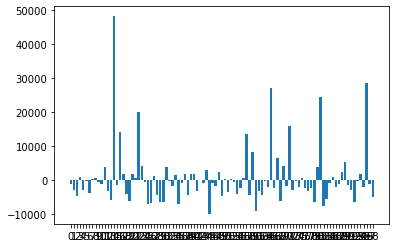

In [234]:
g = [f'{i}' for i in range(len(balances))]
plt.bar(g,balances)
plt.show

In [240]:
balances = np.array(balances)
print(f'Maximum reward for a single combination: {balances.max()}')
print(f'Minimum reward for a single combination: {balances.min()}')
print(f'Total number of winning combinations: {(balances > 0).sum()}')
print(f'Total number of losing combinations: {(balances < 0).sum()}')
print(f'Total reward (sum of the winning combinations): {balances[balances > 0].sum()}')
print(f'Total loses (sum of the losing combinations): {balances[balances < 0].sum()}')

Maximum reward for a single combination: 48270.0
Minimum reward for a single combination: -9960.0
Total number of winning combinations: 37
Total number of losing combinations: 62
Total reward (sum of the winning combinations): 259390.0
Total loses (sum of the losing combinations): -204940.0


### Check numbers frequency

In [22]:
# get the data to a series
frequencies = data.values.flatten().tolist()
freq_series = pd.Series(frequencies).value_counts()
freq_series = (freq_series - freq_series.min()) / freq_series.min() # get the variance
freq_series.index = freq_series.index.astype(int)

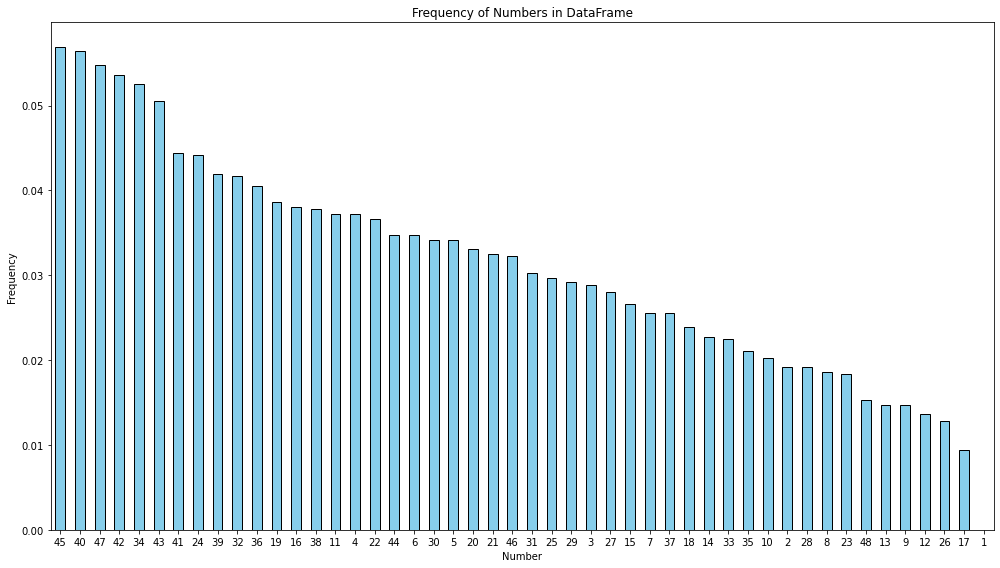

In [23]:
plt.figure(figsize=(14, 8))

freq_series.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Frequency of Numbers in DataFrame')
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # To keep the x-axis labels horizontal
plt.tight_layout()
plt.show()